In [0]:
import numpy as np
from matplotlib.pyplot import *
import sys
def progress_bar(i,n):
    if n != 1:
        ntot=50
        ndone=ntot*i/(n-1)
        a='\r|'
        for k in np.arange(ndone):
            a += '#'
        for k in np.arange(ntot-ndone):
            a += ' '
        a += '| '+str(int(i*100./(n-1)))+'%'
        sys.stdout.write(a)
        sys.stdout.flush()
        if i == n-1:
            sys.stdout.write(' Done \n')
            sys.stdout.flush()
            


Essai de fit de droite avec Keras...

In [0]:
nreal = 50000   ### Better with 100000
ndata = 10
signoise = 0.
xmin = 0.
xmax = 1.
amin = -10
amax = 10.
bmin = -10.
bmax = 10.

truevals = np.zeros((nreal, 2))
xvalues = np.zeros((nreal, ndata))
yvalues = np.zeros((nreal, ndata))

for i in xrange(nreal):  
  progress_bar(i,nreal)
  xx = np.random.rand(ndata)*(xmax-xmin)+xmin
  aval = np.random.rand()*(amax-amin)+amin
  bval = np.random.rand()*(bmax-bmin)+bmin
  noise = np.random.randn(ndata)*signoise
  yy = aval * xx + bval + noise
  truevals[i,0] = aval
  truevals[i,1] = bval
  xvalues[i,:] = xx
  yvalues[i,:] = yy
  


|#############################################     | 90%

In [1]:
itry = np.random.randint(nreal)
errorbar(xvalues[itry,:],yvalues[itry,:], yerr=np.zeros(ndata)+signoise, fmt='ro')
xxx = np.linspace(xmin,xmax,100)
plot(xxx, truevals[itry,0]*xxx+truevals[itry,1])
title(itry)

NameError: ignored

In [6]:
### Deep Networks Configuration
from tensorflow import keras
from keras.models import Sequential
model = Sequential()

from keras.layers import Dense
model.add(Dense(units=ndata*6, input_dim=ndata*2, kernel_initializer='uniform', activation='relu'))
model.add(Dense(units=2, kernel_initializer='uniform', activation='linear'))

model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

X_train = np.concatenate((xvalues,yvalues), axis=1)
Y_train = truevals.copy()

### Renormnalization to get inputs and outputs between 0 and 1
max_x=np.max(X_train)
max_y=np.max(Y_train)
X_train=X_train/max_x
Y_train=Y_train/max_y

from __future__ import print_function
class PrintNum(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: 
      print('')
      print(epoch, end='')
    sys.stdout.write('.')
    sys.stdout.flush()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

## Better with epoch=3000
history=model.fit(X_train,Y_train, epochs=3000, batch_size=100, validation_split=0.2, verbose=0, callbacks=[early_stop, PrintNum()])

Using TensorFlow backend.



0....................................................................................................
100....................................................................................................
200....................................................................................................
300....................................................................................................
400....................................................................................................
500....................................................................................................
600...............

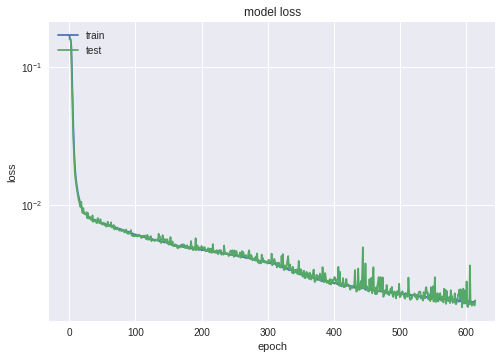

0.0019201185183919734 0.0018040247159660794 615


In [7]:
# summarize history for loss
plot(history.history['loss'])
plot(history.history['val_loss'])
title('model loss')
ylabel('loss')
xlabel('epoch')
legend(['train', 'test'], loc='upper left')
yscale('log')
show()
print(min(history.history['loss']), min(history.history['val_loss']), len(history.history['val_loss']))

100000/100000 [==============================] - 3s 31us/step
(100000, 2)


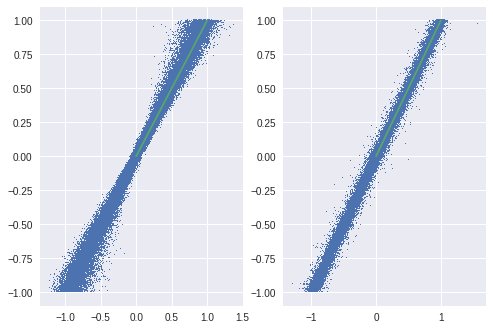

In [8]:
Y_trainPredict = model.predict(X_train,verbose=1)
print(Y_trainPredict.shape)

xxx = np.linspace(0,1,100)
subplot(1,2,1)
plot(Y_trainPredict[:,0], Y_train[:,0],',')
plot(xxx,xxx)
subplot(1,2,2)
plot(Y_trainPredict[:,1], Y_train[:,1],',')
plot(xxx,xxx)

In [9]:
ntest = 1000

truevals_test = np.zeros((ntest, 2))
xtest = np.zeros((ntest, ndata))
ytest = np.zeros((ntest, ndata))

for i in xrange(ntest):  
  progress_bar(i,ntest)
  xx = np.random.rand(ndata)*(xmax-xmin)+xmin
  aval = np.random.rand()*(amax-amin)+amin
  bval = np.random.rand()*(bmax-bmin)+bmin
  noise = np.random.randn(ndata)
  yy = aval * xx + bval
  truevals_test[i,0] = aval
  truevals_test[i,1] = bval
  xtest[i,:] = xx
  ytest[i,:] = yy
  
X_test = np.concatenate((xtest,ytest), axis=1)

|##################################################| 100% Done 


1000/1000 [==============================] - 0s 35us/step


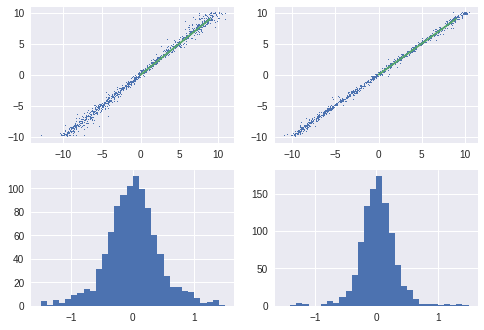

In [10]:
Y_Predict = model.predict(X_test/max_x,verbose=1)*max_y
subplot(2,2,1)
plot(Y_Predict[:,0], truevals_test[:,0],',')
plot(range(10),range(10))
subplot(2,2,2)
plot(Y_Predict[:,1], truevals_test[:,1],',')
plot(range(10),range(10))
subplot(2,2,3)
bla = hist(Y_Predict[:,0] - truevals_test[:,0], bins=30, range=[-1.5,1.5])
subplot(2,2,4)
bla = hist(Y_Predict[:,1] - truevals_test[:,1], bins=30, range=[-1.5,1.5])


Maintenant en ajoutant du bruit sur le lot de test

|##################################################| 100% Done 


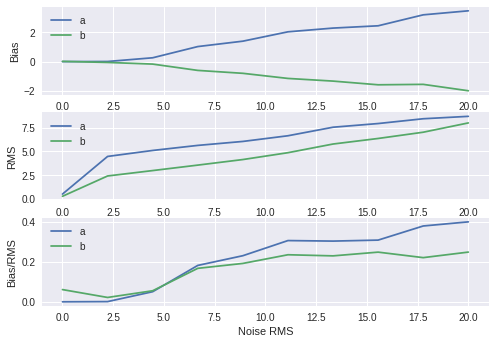

In [11]:
nnoise = 10
sigmin = 0.
sigmax = 20.
allsignoise = np.linspace(sigmin, sigmax, nnoise)

mbias_a = np.zeros(nnoise)
mbias_b = np.zeros(nnoise)
rms_a = np.zeros(nnoise)
rms_b = np.zeros(nnoise)

for i in xrange(nnoise):
  progress_bar(i,nnoise)
  thenoisey = np.random.randn(ntest,ndata)*allsignoise[i]
  theX_test = np.concatenate((xtest,ytest + thenoisey), axis=1)
  theY_Predict = model.predict(theX_test/max_x,verbose=0)*max_y
  res_a = theY_Predict[:,0] - truevals_test[:,0]
  mbias_a[i] = np.mean(res_a)
  rms_a[i] = np.std(res_a)
  res_b = theY_Predict[:,1] - truevals_test[:,1]
  mbias_b[i] = np.mean(res_b)
  rms_b[i] = np.std(res_b)
  

  
subplot(3,1,1)
plot(allsignoise, mbias_a, label='a')
plot(allsignoise, mbias_b, label='b')
ylabel('Bias')
xlabel('Noise RMS')
legend()
subplot(3,1,2)
plot(allsignoise, rms_a, label='a')
plot(allsignoise, rms_b, label='b')
xlabel('Noise RMS')
ylabel('RMS')
legend()
subplot(3,1,3)
plot(allsignoise, np.abs(mbias_a) / rms_a, label='a')
plot(allsignoise, np.abs(mbias_b) / rms_b, label='b')
xlabel('Noise RMS')
ylabel('Bias/RMS')
legend()


1.2430128978691461 0.7067584161881348


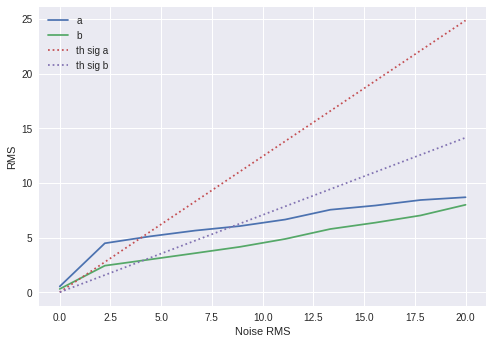

In [12]:
# analytical calculation of optimal error on a and b for sig=1
all_a = np.zeros((ntest, ndata,2))
all_a[:,:,0] = xtest
all_a[:,:,1] = 1
allcov = np.zeros((ntest,2,2))
for i in xrange(ntest):
  allcov[i,:,:] = np.linalg.inv(np.dot(all_a[i,:,:].T, all_a[i,:,:]))
  
cov = np.mean(allcov, axis=0)
sig_a = np.sqrt(cov[0,0]) * allsignoise
sig_b = np.sqrt(cov[1,1]) * allsignoise
print(np.sqrt(cov[0,0]), np.sqrt(cov[1,1]))

  
plot(allsignoise, rms_a, label='a')
plot(allsignoise, rms_b, label='b')
plot(allsignoise, sig_a, ':', label='th sig a')
plot(allsignoise, sig_b, ':', label='th sig b')
xlabel('Noise RMS')
ylabel('RMS')
legend()


In [13]:
# MC 
print(ytest.shape)
rms_ab_mc = np.zeros((nnoise,2))
for i in xrange(nnoise):
  thenoisey = np.random.randn(ntest,ndata)*allsignoise[i]
  ab = np.zeros((ntest,2))
  for k in xrange(ntest):
    atam1_at = np.dot(np.linalg.inv(np.dot(all_a[k,:,:].T, all_a[k,:,:])), all_a[k,:,:].T)
    ab[k,:] = np.dot(atam1_at, ytest[k,:] + thenoisey[k,:])
  rms_ab_mc[i,:] = np.std(ab, axis = 0)  
  


(1000, 10)


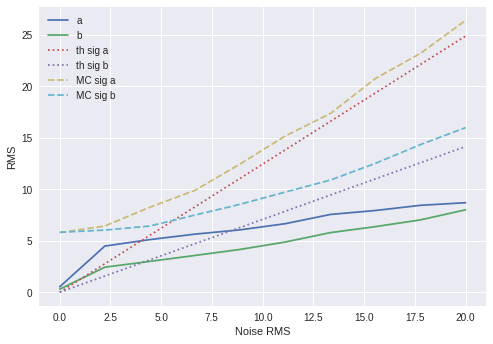

In [14]:
plot(allsignoise, rms_a, label='a')
plot(allsignoise, rms_b, label='b')
plot(allsignoise, sig_a, ':', label='th sig a')
plot(allsignoise, sig_b, ':', label='th sig b')
plot(allsignoise, rms_ab_mc[:,0], '--', label='MC sig a')
plot(allsignoise, rms_ab_mc[:,1], '--', label='MC sig b')
xlabel('Noise RMS')
ylabel('RMS')
legend()


Absurde de trouver un plus petit RMS avec ML qu'avec fit direct...

Essaons de regarder directement les samples pur une valeur de bruit donnée

In [1]:
thesignoise = 15
thenoisey = np.random.randn(ntest,ndata)*thesignoise
theX_test = np.concatenate((xtest,ytest + thenoisey), axis=1)

theY_Predict = model.predict(theX_test/max_x,verbose=0)*max_y
res_a = theY_Predict[:,0] - truevals_test[:,0]
res_b = theY_Predict[:,1] - truevals_test[:,1]

ab = np.zeros((ntest,2))
for k in xrange(ntest):
  atam1_at = np.dot(np.linalg.inv(np.dot(all_a[k,:,:].T, all_a[k,:,:])), all_a[k,:,:].T)
  ab[k,:] = np.dot(atam1_at, ytest[k,:] + thenoisey[k,:])

figure()
plot(ab[:,0], ab[:,1],'.', label = 'Chi2')
plot(theY_Predict[:,0], theY_Predict[:,1],'.', label = 'Machine Learning')
plot(truevals_test[:,0], truevals_test[:,1],'.', label = 'True')
legend()
title('Values')

figure()
plot(ab[:,0]-truevals_test[:,0], ab[:,1]-truevals_test[:,1],'.', label = 'Chi2')
plot(theY_Predict[:,0]-truevals_test[:,0], theY_Predict[:,1]-truevals_test[:,1],'.', label = 'Machine Learning')
legend()
title('Residuals')

figure()
subplot(1,2,1)
ss = np.max([np.std(ab[:,0]-truevals_test[:,0]), np.std(theY_Predict[:,0]-truevals_test[:,0])])
ns = 3
hist(ab[:,0]-truevals_test[:,0], bins=20, range=[-3*ss,3*ss], alpha=0.5, label = 'Chi2')
hist(theY_Predict[:,0]-truevals_test[:,0], bins=20, range=[-3*ss,3*ss], alpha=0.5, label = 'Machine Learning')
title('a')
legend()
subplot(1,2,2)
ss = np.max([np.std(ab[:,1]-truevals_test[:,1]), np.std(theY_Predict[:,1]-truevals_test[:,1])])
ns = 3
hist(ab[:,1]-truevals_test[:,1], bins=20, range=[-3*ss,3*ss], alpha=0.5, label = 'Chi2')
hist(theY_Predict[:,1]-truevals_test[:,1], bins=20, range=[-3*ss,3*ss], alpha=0.5, label = 'Machine Learning')
title('b')
legend()



NameError: ignored

inexpliquable...